# Biofysikk prosjekt

In [1]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
print("Hei")

Hei


#### Grunnleggende polymer-funksjonalitet
Vi representerer hvert polymer i et array med dimensjon Nx2, hvor vi lagrer posisjonen til hvert monomer ved hjelp av koordinatene til monomeret ved hjelp av radene og kolonnene i arrayet. En annen metode hadde vært å lagre et array med dimensjon MxM, altså hele gitteret. Da hadde de resterend koordinatene hadde bestått av nullere. Siden vi er bare interresert i posisjonen til N monomerer velger vi å lagre dataen i et Nx2 array siden dette er mye raskere. (Finne ut hvor mye raskere/hvor mye midre tid dette tar). (Skriv noe mer om M)

In [4]:
N = 7  # Lengde på polymer
M = 9  # Gitterdimensjon

#Definerer først polymer som er et Nx2 array med datatype 32 bit
def init_polymer(N):
    polymer = np.zeros((N, 2), dtype=np.int32)
    print(polymer[:,1])
    polymer[:, 1] = np.arange(N)
    polymer[:, 0] = M // 2
    return polymer

init_polymer(N)

[0 0 0 0 0 0 0]


array([[4, 0],
       [4, 1],
       [4, 2],
       [4, 3],
       [4, 4],
       [4, 5],
       [4, 6]], dtype=int32)

1c) Dersom et polymer roteres om et endepunkt, så vil det ikke endre noe og polymeren vil forbli i ro, da vi har valgt at det er den korte siden som skal roteres. Dermed vil det ikke oppstå noen nye vekselvirkninger og energien vil forbli den samme som før rotasjonen. Dette medfører at det vil være hensiksmessig å ikke inkludere endemonomeren i det tilfeldige utvalget monomeren trekkes fra. Vi vil derfor kun trekke fra 1 til N-1 i arrayet når vi skal velge hvilket monomer som skal roteres rundt.

[0 0 0 0 0 0 0]


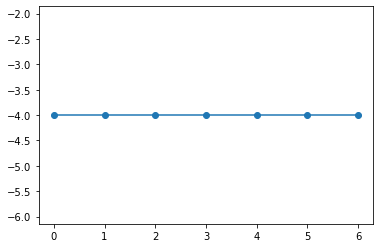

In [7]:
def plot_polymer(polymer):
    plt.plot(polymer[:, 1], -polymer[:, 0], 'o-')
    plt.axis('equal')
    plt.show()

plot_polymer(init_polymer(N))



[0 0 0 0 0 0 0]


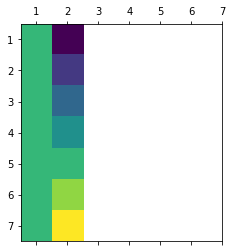

In [21]:
def plot_array_in_grid(array):
    cols, rows = array.shape

    # Create a grid of subplots
    fig, ax = plt.subplots()
    cax = ax.matshow(array, cmap='viridis')  # 'viridis' is just an example colormap

    # Set ticks and labels
    ax.set_xticks(np.arange(cols))
    ax.set_yticks(np.arange(cols))
    ax.set_xticklabels(np.arange(1, cols + 1))
    ax.set_yticklabels(np.arange(1, cols + 1))

    plt.show()

plot_array_in_grid(init_polymer(N))

In [30]:
def polymerCheck(polymer, N):
    if len(polymer) != N:
        return False
    for i in range(N):
        for j in range(N):
            if i != j:
                if polymer[i] == polymer[j]:
                    return False
    for i in range(N):
        if i == 0:
            a=1
    #Få til 3. 

    return True

print(polymerCheck(list(init_polymer(7)), 7))

True


In [11]:
from numba import jit, njit
# njit: No-Python mode JIT (Just-In-Time compilation)

CW_ROTATION_MATRIX = ...
CCW_ROTATION_MATRIX = ...

# @njit
def rotate_polymer(polymer: np.ndarray, clockwise: bool) -> np.ndarray:
    """
    polymer: input polymer (or sub-polymer) (N x 2)
    clockwise: direction of rotation
    """
    # Rotate the polymer by 90 degrees in the right direction (matrix multiplication with rotation matrix, follow `clockwise`)
    # Use the rotation matrices defined in constants above
    rotation_matrix = ... # Choose the right rotation matrix
    rotated_polymer: np.ndarray = polymer @ rotation_matrix.T

    return rotated_polymer

# @njit
def twist_polymer(polymer: np.ndarray, monomer_idx: int, clockwise: bool) -> np.ndarray:
    """
    polymer: input polymer (N x 2)
    monomer_idx: index of monomer to twist
    clockwise: direction of twist
    """
    # Check which side is shorter
    shorter_side = ...  # True if shorter side is 0..=monomer_idx-1, False if shorter side is monomer_idx+1..=N-1

    # Slice array to get the smaller side
    shorter_sub_polymer: np.ndarray = ...

    # Translate the shorter sub-polymer to origin at polymer[monomer_idx]
    center = polymer[monomer_idx]
    centered_sub_polymer: np.ndarray = ...

    # Rotate the shorter sub-polymer by 90 degrees in the right direction (matrix multiplication with rotation matrix, follow `clockwise`)
    # Use the rotation matrices defined in constants above
    rotated_sub_polymer: np.ndarray = ...

    # Translate back to get final sub_polymer position
    twisted_sub_polymer: np.ndarray = ...

    # Combine the two sub-polymers into a new polymer
    twisted_polymer: np.ndarray = np.concatenate((..., ...), axis=0)

    return twisted_polymer

# @njit uncomment!
def valid_polymer(polymer: np.ndarray) -> bool:
    # Needs to be fast!
    raise NotImplementedError()

def random_rotations(polymer: np.ndarray, N_s: int) -> np.ndarray:
    """
    polymer: input polymer (N x 2)
    N_s: number of random rotation attempts
    """
    counter = 0  # TODO: Make sure this is correct -- ask TA
    current_polymer = polymer
    clockwise_draws = np.random.rand(N_s) < 0.5
    mon_idx_draws = np.random.randint(1, N - 1, size=N_s)  # Exclusive range [1, N-1), don't include end points
    for i in range(N_s):
        clockwise = clockwise_draws[i]
        mon_idx = mon_idx_draws[i]
        twisted_polymer = twist_polymer(polymer=current_polymer, monomer_idx=mon_idx, clockwise=clockwise)
        if valid_polymer(twisted_polymer):
            counter += 1
            current_polymer = twisted_polymer
    return current_polymer, counter

In [12]:
# @njit
def add_one(x):
    for i in range(x.shape[0]):
        x[i] += 1

@njit
def add_one_numba(x):
    for i in range(x.shape[0]):
        x[i] += 1

arr = np.arange(10_000_000)

In [13]:
%timeit add_one(arr)
%timeit add_one_numba(arr)

2.2 s ± 39.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
7.46 ms ± 468 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
def calculate_energy(twisted_polymer: np.ndarray, V: np.ndarray) -> float:
    """
    twisted_polymer: input polymer (N x 2)
    V: interaction matrix (N x N)
    """